# Part III: Generative Adversarial Networks
- GAN
    - Introduction: What is GAN?
    - Optimization
    - Theoretical Analysis of GAN. 
- WGAN
    - Wasserstein-1 Distance

## Generative Adversarial Networks (GAN)

### Introduction: What is GAN?
A generative adversarial network can be viewed as a two-player game involving a **generator** and a **discriminator**. The generator plays the role of a counterfeiter attempting to create fake currency, while the discriminator acts as the police, aiming to distinguish legitimate money from counterfeit money.

**Notation and Termonology.** In the following discussion, we denote $G$ for the generator network with its parameter $\theta^G$, $D$ for the discriminator network with its parameter $\theta^D$, $\mathcal{X}$ the image space, for example $\mathbb{R}^{256\times 256}$, $p_{data}$ the data distribution in $\mathcal{X}$, $p_g$ the data distribution in $\mathcal{X}$ generated by $G$, $\mathcal{Z}$ for the latent space, and $p_z$ the noise distribution in $\mathcal{Z}$. Also, we refer to a neural network fixed as its parameters are fixed.

The generator $G$, a map from $\mathcal{Z}\to\mathcal{X}$, is a differentiable neural network that generates fake images. Usually, the dimension of $\mathcal{Z}$ is much smaller than $\mathcal{X}$, which means $G$ is map from a low dimensional space to a high dimensional space. The discriminator, a differentiable neural network that maps $\mathcal{X}\to [0,1]$, on the otherhand, outputs a scalar in $[0,1]$ that the probability of the input image of $D$ is **real**. If $D(\hat{\mathbf{x}})$ is greater than or equal to $0.5$, then the discriminator identifies $\hat{\mathbf{x}}$ as a real image, or otherwise, $\hat{\mathbf{x}}$ is fake.

Their interaction can be illustrated as below:
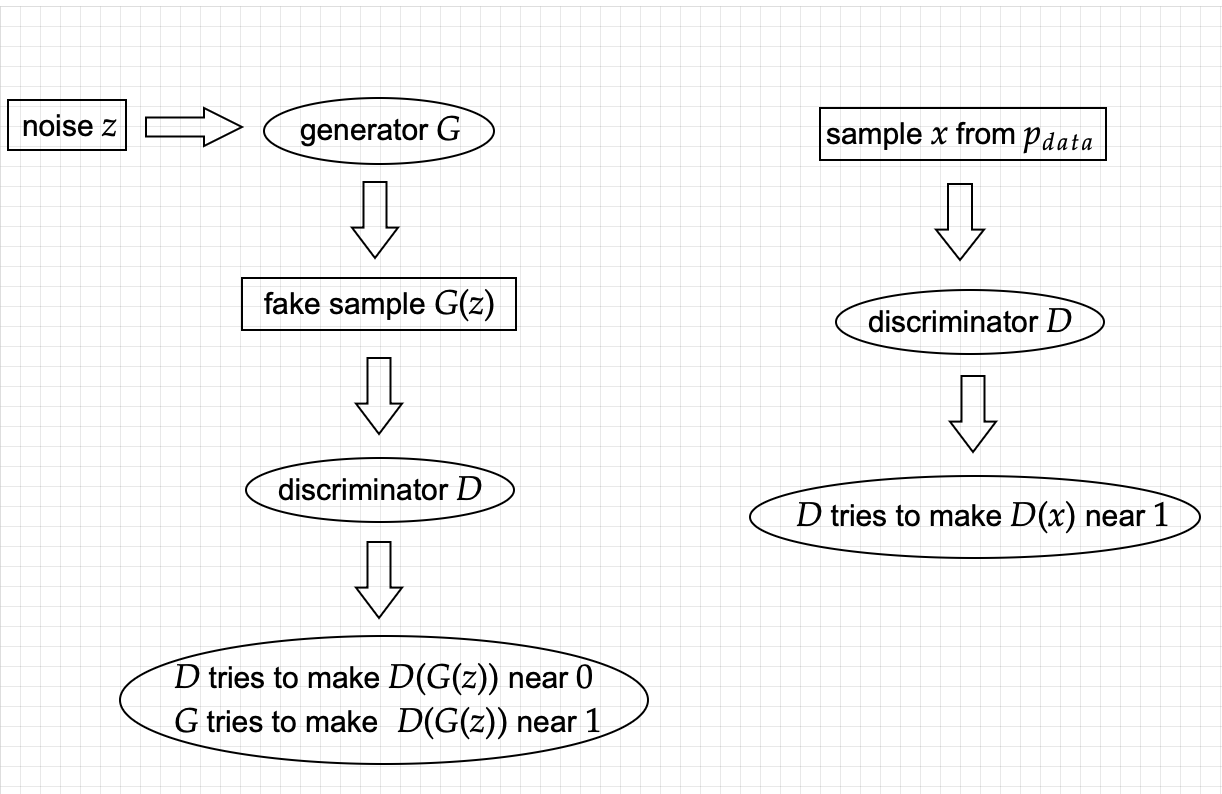



### Optimization
#### Loss Function
Both players have loss functions that are defined on $\theta^G$ and $\theta^D$. The discriminator wishes to minimize $L_D=L_D(\theta^G,\theta^D)$ and must do while controlling only $\theta^D$. The generator wishes to minimize $L_G=L_G(\theta^G,\theta^D)$ and must do while controlling only $\theta^G$. 

$L_D$ usually is defined as 
$$
L_D(\theta^G,\theta^D)= -\mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log D(\hat{\mathbf{x}})\right]-\mathbb{E}_{\hat{\mathbf{z}}\sim p_z} \left[\log (1-D(G(\hat{\mathbf{z}})))\right].
$$
Here comes the tricky part of GAN. In the original paper, GAN is considered to be a **zero-sum** game, and thus $L_G$ is defined as
$$
L_G(\theta^G,\theta^D)=-L_D(\theta^G,\theta^D).
$$
With this setting, GAN can be formulated as a **min-max** game, namely
$$
\min_G\max_D \mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log D(\hat{\mathbf{x}})\right]+\mathbb{E}_{\hat{\mathbf{z}}\sim p_z} \left[\log (1-D(G(\hat{\mathbf{z}})))\right].
$$
Theoretically, there's no problem to define $L_G$ in this way. 

**Theorem.** For $G$ fixed, i.e. the parameter $\theta^G$ fixed, the optimal discriminator $D$ satisfies
$$
D^*_G(\mathbf{x})=\frac{p_{data}(\mathbf{x})}{p_{g}(\mathbf{x})+p_{data}(\mathbf{x})}.
$$
**Proof.** 
$$
\begin{aligned}
& \int_{\hat{\mathbf{x}}} p_{data}(\hat{\mathbf{x}}) \log D(\hat{\mathbf{x}}) d\hat{\mathbf{x}}+\int_{\hat{\mathbf{z}}} p_{\hat{\mathbf{z}}}(\hat{\mathbf{z}}) \log(1-D(G(\hat{\mathbf{z}}))) d\hat{\mathbf{z}}\\
& = \int_{\hat{\mathbf{x}}} p_{data}(\hat{\mathbf{x}}) \log D(\hat{\mathbf{x}})+p_g(\hat{\mathbf{x}})\log(1-D(\hat{\mathbf{x}})) d\hat{\mathbf{x}}
\end{aligned}
$$
For any $(a,b)\in\mathbb{R}^2\setminus \{0\}$, $y \mapsto a\log(y)+b\log(1-y)$ attains maximum in $[0,1]$ at $\frac{a}{a+b}$, so for optimal $D^*_G$, 
$$
D^*_G(\hat{\mathbf{x}})=\frac{p_{data}(\hat{\mathbf{x}})}{p_{g}(\hat{\mathbf{x}})+p_{data}(\hat{\mathbf{x}})}. \quad \blacksquare
$$
With this, for a fixed generator $G$, $L_G$ can be written as
$$
\begin{aligned}
L_G & = \max_D \mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log D(\hat{\mathbf{x}})\right]+\mathbb{E}_{\hat{\mathbf{z}}\sim \mathcal{N}(0,\mathbf{I})} \left[\log (1-D(G(\hat{\mathbf{z}})))\right] \\
& = \mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log D^*_G(\hat{\mathbf{x}})\right]+\mathbb{E}_{\hat{\mathbf{z}}\sim \mathcal{N}(0,\mathbf{I})} \left[\log (1-D^*_G(G(\hat{\mathbf{z}})))\right] \\
& = \mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log D^*_G(\hat{\mathbf{x}})\right]+\mathbb{E}_{\hat{\mathbf{x}}\sim p_g} \left[\log (1-D^*_G(\hat{\mathbf{x}}))\right] \\
& = \mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log \frac{p_{data}(\hat{\mathbf{x}})}{p_{data}(\hat{\mathbf{x}})+p_{g}(\hat{\mathbf{x}})}\right]+\mathbb{E}_{\hat{\mathbf{x}}\sim p_{g}}\left[\log \frac{p_{g}(\hat{\mathbf{x}})}{p_{data}(\hat{\mathbf{x}})+p_{g}(\hat{\mathbf{x}})}\right]
\end{aligned}
$$
The equation tells us the global minimum of $L_G$ happens if and only if $p_g=p_{data}$. To see this, observe that  $\hat{\mathbf{x}}$ is either real or fake, if $p_g=p_{data}$, $D^*_G(\hat{\mathbf{x}})=\frac{1}{2}$ for all $\hat{\mathbf{x}}$ and hence 
$$
\mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log \frac{1}{2}\right]+\mathbb{E}_{\hat{\mathbf{x}}\sim p_g} \left[\log (1-\frac{1}{2})\right] = 2\log\frac{1}{2} = -\log 4. 
$$
By subtracting $2\log\frac{1}{2}$, we obtain
$$
\begin{aligned}
L_G & = -\log 4 + KL(p_{data}||\frac{p_{data}+p_g}{2}) + KL(p_{g}||\frac{p_{data}+p_g}{2}) \\
& = -\log 4 + 2\times JSD(p_{data} || p_g).
\end{aligned}
$$
In other words, minimizing $L_G$ is equivalent to minimizing JS divergence between $p_{data}$ and $p_g$. Moreover, if $G$ is optimal, then $L_G$ achieves then value $-\log 4$ because the JS divergence is always non-negative and zero when $p_g$ and $p_{data}$ are equal.

However, we observe the **gradient vanishing** through the training of GAN, and in fact, the gradient vanishing problem could be analyzed from the theoretical aspect.

Initially, the generator $G$ is poor. The discriminator could easily tell the generated images by $G$ from real images. As a result, $D(G(\hat{\mathbf{z}}))$ is almost zero, and $G$ is unable to update due to small changes in $L_G=-L_D$.

Nowadays, people usually uses the alternative
$$
L_G(\theta^G,\theta^D) = -\mathbb{E}_{\hat{\mathbf{z}}\sim p_z} \left[\log (D(G(\hat{\mathbf{z}})))\right].
$$
Intuitively, this form alleviates the gradient vanishing because when $G$ is poor, $D(G(\hat{\mathbf{z}}))$ is almost zero, and thus $-\log D(G(\hat{\mathbf{z}}))>0$ is large, inducing huge loss and effective gradient. Unfortunately, this form of $L_G$ induces the unstable training of GAN. We will give the analysis in the section "Theoretical Analysis of GAN". 

#### Estimation of Loss and its Gradient
Now assume 
$$
L_D(\theta^G,\theta^D) = -\mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log D(\hat{\mathbf{x}})\right]-\mathbb{E}_{\hat{\mathbf{z}}\sim p_z} \left[\log (1-D(G(\hat{\mathbf{z}})))\right]
$$ 
and 
$$
L_G(\theta^G,\theta^D) = -\mathbb{E}_{\hat{\mathbf{z}}\sim p_z} \left[\log (D(G(\hat{\mathbf{z}})))\right].
$$
Thanks to Monte Carlo estimation, we can implement two expectations as
$$
\widetilde{L_D} = -\frac{1}{m}\sum_{i=1}^m \ln D(\hat{\mathbf{x}}^{(i)})-\frac{1}{m}\sum_{i=1}^m \ln(1-D(G(\hat{\mathbf{z}}^{(i)})))
$$
and
$$
\widetilde{L_G} = -\frac{1}{m}\sum_{i=1}^m \ln(D(G(\hat{\mathbf{z}}^{(i)}))).
$$
There's no restriction on the choice of $p_z$. In practice, people usually choose $\hat{\mathbf{z}}^{(i)}\sim\mathcal{N}(0,\mathbf{I})$. 

In general, calculating $\nabla_{\theta^D} L_D$ is difficult because we have to calculate the expecation first and then take gradient. However, the intractable integral now becomes an average of summation, so the gradient 
$$
\nabla_{\theta^D}\widetilde{L_D} = \nabla_{\theta^D}-\frac{1}{m}\sum_{i=1}^m \ln D(\hat{\mathbf{x}}^{(i)})-\nabla_{\theta^D}\frac{1}{m}\sum_{i=1}^m \ln(1-D(G(\hat{\mathbf{z}}^{(i)})))
$$
becomes tractable. Similarly, 
$$
\nabla_{\theta^G}\widetilde{L_G} = \nabla_{\theta^G}-\frac{1}{m}\sum_{i=1}^m \ln(D(G(\hat{\mathbf{z}}^{(i)}))).
$$
The calculation of the right hand side of $\nabla_{\theta^D}\widetilde{L_D}$ and $\nabla_{\theta^G}\widetilde{L_G}$ can be finished with autodifferentiation. Remember that $\nabla_{\theta^D}L_D$ means we calculate the partial derivatives of $L_D$ with respect to every weight and bias in every layer of our neural network.

#### Training
Initialize $\theta^D,\theta^G$

**for** each training iteration **do**

$\quad$**for** $K$ steps **do**

$\quad\quad$ Sample batch of $m$ noise vectors $\hat{\mathbf{z}}^{(i)}$ 

$\quad\quad$ Sample batch of $m$ examples $\hat{\mathbf{x}}^{(i)}$ 

$\quad\quad$ Update the discriminator by performing stochastic gradient descent using
$$
\nabla_{\theta^D}\frac{1}{m}\sum_{i=1}^m\left[-\log D(\hat{\mathbf{x}}^{(i)})-\log (1-D(G(\hat{\mathbf{z}}^{(i)})))\right]
$$
**end for**

$\quad$ Sample batch of $m$ noise vectors $z_i$

$\quad$ Update the generator by performing stochastic gradient descent using
$$
\nabla_{\theta^G}\frac{1}{m}\sum_{i=1}^m\left[-\log D(G(\hat{\mathbf{z}}^{(i)}))\right]
$$
**end for**

### Theoretical Analysis of GAN

**Theorem a.** If two distributions $p_{data}$ and $p_g$ have support contained on two disjoint compact subsets $\mathcal{M}$ and $\mathcal{P}$ respectively, then there is a smooth optimal discrimator $D^*:\mathcal{X}\to [0,1]$ that has accuracy 1 and $\nabla_x D^*(x)=0$ for all $x\in\mathcal{M}\cup\mathcal{P}$.

**Theorem b.** Let $p_{data}$ and $p_g$ be two distributions that have support contained in two closed manifolds $\mathcal{M}$ and $\mathcal{P}$ that don’t perfectly align and don’t have full dimension. We further assume that $p_{data}$ and $p_g$ are continuous in their respective manifolds, meaning that if there is a set $A$ with measure $0$ in $\mathcal{M}$, then $p_{data}(A)=0$ (and analogously for $p_g$). Then, there exists an optimal discriminator $D^*:\mathcal{X}\to [0,1]$ that has accuracy $1$ and for almost any $x$ in $\mathcal{M}$ or $\mathcal{P}$, $D^*$ is smooth in an neighbourhood of $x$ and $\nabla_x D^*(x)=0$.

Theorem a and b basically tell us that there exist perfect discriminators which are smooth and constant almost everywhere in $\mathcal{M}$ and $\mathcal{P}$. The fact that the discriminator is perfect implies that we cannot learn anything through backpropagation.

**Theorem 1.(Vanishing gradients on the generator)** If conditions of Theorem a or Theorem b are satisfied, $\|D-D^*\|<\epsilon$, and $\mathbb{E}$, then
$$
\|\nabla_{\theta^D}\mathbb{E}_{\hat{\mathbf{z}}\sim p_z}\left[\log(1-D(G(\hat{\mathbf{z}})))\right]\|_2<M\frac{\epsilon}{1-\epsilon}.
$$
**Corolary 2.** Under the same assumptions of Theorem 1, 
$$
\lim_{\|D-D^*\|\to 0} \mathbb{E}_{\hat{\mathbf{z}}\sim p_z}\left[\log(1-D(G(\hat{\mathbf{z}})))\right] = 0.
$$
Theorem 1 and Corolary 2 shows that as the discriminator gets better, the gradient of $L_G$ vanishes. 

**Theorem 3.(Instability of generator gradient updates)** Suppose either the conditions of Theorem a or Theorem b are satisfied. Let $D$ be a discriminator such that $D(\hat{\mathbf{x}})-D^*(\hat{\mathbf{x}})=\epsilon$ is a centered Gaussian process indexed by $\hat{\mathbf{x}}$ and independent for every $\hat{\mathbf{x}}$ and $\nabla_{\hat{\mathbf{x}}}D(\hat{\mathbf{x}})-\nabla_{\hat{\mathbf{x}}}D^*(\hat{\mathbf{x}})=r$ another independent centered Gaussian process indexed by $\hat{\mathbf{x}}$ and independent for every $\hat{\mathbf{x}}$. Then, each coordinate of
$$
\mathbb{E}_{\hat{\mathbf{z}}\sim p_z} \left[\log (D(G(\hat{\mathbf{z}})))\right]
$$
is a centered Cauchy distribution with **infinite expectation and variance**. 

## Wasserstein GAN (WGAN)

In essence, the objective of GAN is to attain the convergence of the generator distribution $p_g$ to the data distribution $p_{data}$. To grasp the notion of convergence, it is essential to initially establish the distance between two distributions.

### Wasserstein-1 Distance
**Fact $(*)$.** A sequence of distributions $(p_t)_{t\in\mathbb{N}}$ converges with respect to the distance or divergence, $\rho$, if and only if there is a distribution $p_{\infty}$ such that $\rho(p_t,p_{\infty})$ tends to zero. 

If we are able to define a divergence so that $(*)$ holds, then we can employ gradient descent methods to improve our model. The distance that satisfies $(*)$ does exists, which is Wasserstein-1 distance. 

**Definition.** Wasserstein-1 distance
$$
W(p_{data},p_g) = \inf_{\gamma\in\Pi(p_{data},p_g)} \mathbb{E}_{(\hat{\mathbf{x}},\hat{\mathbf{y}})\sim \gamma}\left[\|\hat{\mathbf{x}}-\hat{\mathbf{y}}\|\right]
$$
where $\Pi(p_{data},p_g)$ denotes the set of all joint distributions $\gamma(\hat{\mathbf{x}},\hat{\mathbf{y}})$ whose marginals are respectively $p_{data}$ and $p_g$. Intuitively, $\gamma(\hat{\mathbf{x}},\hat{\mathbf{y}})$ indicates how much “mass” must be transported from $\hat{\mathbf{x}}$ to $\hat{\mathbf{y}}$ in order to transform the distributions $p_{data}$ into the distribution $p_g$.

**Theorem (Kantorovich-Rubinstein duality).** 
$$
W(p_{data},p_g) = \inf_{\gamma\in\Pi(p_{data},p_g)} \mathbb{E}_{(\hat{\mathbf{x}},\hat{\mathbf{y}})\sim \gamma}\left[\|\hat{\mathbf{x}}-\hat{\mathbf{y}}\|\right]=\sup_{\|f\|_L\leq 1} \mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[f(\hat{\mathbf{x}})\right]-\mathbb{E}_{\hat{\mathbf{x}}\sim p_{g}}\left[f(\hat{\mathbf{x}})\right].
$$

**Assumption 1.** The generator $G$ is said to satisfy assumption 1 for a certain probability distribution $p_z$ over $\mathcal{Z}$ if there are local Lipschitz constants $L(\theta^G,\hat{\mathbf{z}})$ such that 
$$
\mathbb{E}_{\mathbf{z}\sim p_z}\left[L(\theta,\hat{\mathbf{z}})\right]<\infty.
$$

**Theorem.** Let $p_{data}$ be a fixed distribution over $\mathcal{X}$. Let $Z$ be a random variable (e.g Gaussian) over another space $\mathcal{Z}$. Let $G:\mathcal{Z}\to\mathcal{X}$ be a function with parameter $\theta^G$. Let $p_g$ denote the distribution of $G$. Then
1. If $G$ is continuous in $\theta^G$, so is $W(p_{data},p_g)$.
2. If $G$ is locally Lipschitz and satisfies regularity assumption 1, then $W(p_{data},p_g)$ is continuous everywhere, and differentiable almost everywhere.
3. Statements 1 and 2 are false for the Jensen-Shannon divergence and all the KLs.

### Training
The following is the training algorithm proposed in the original WGAN paper.

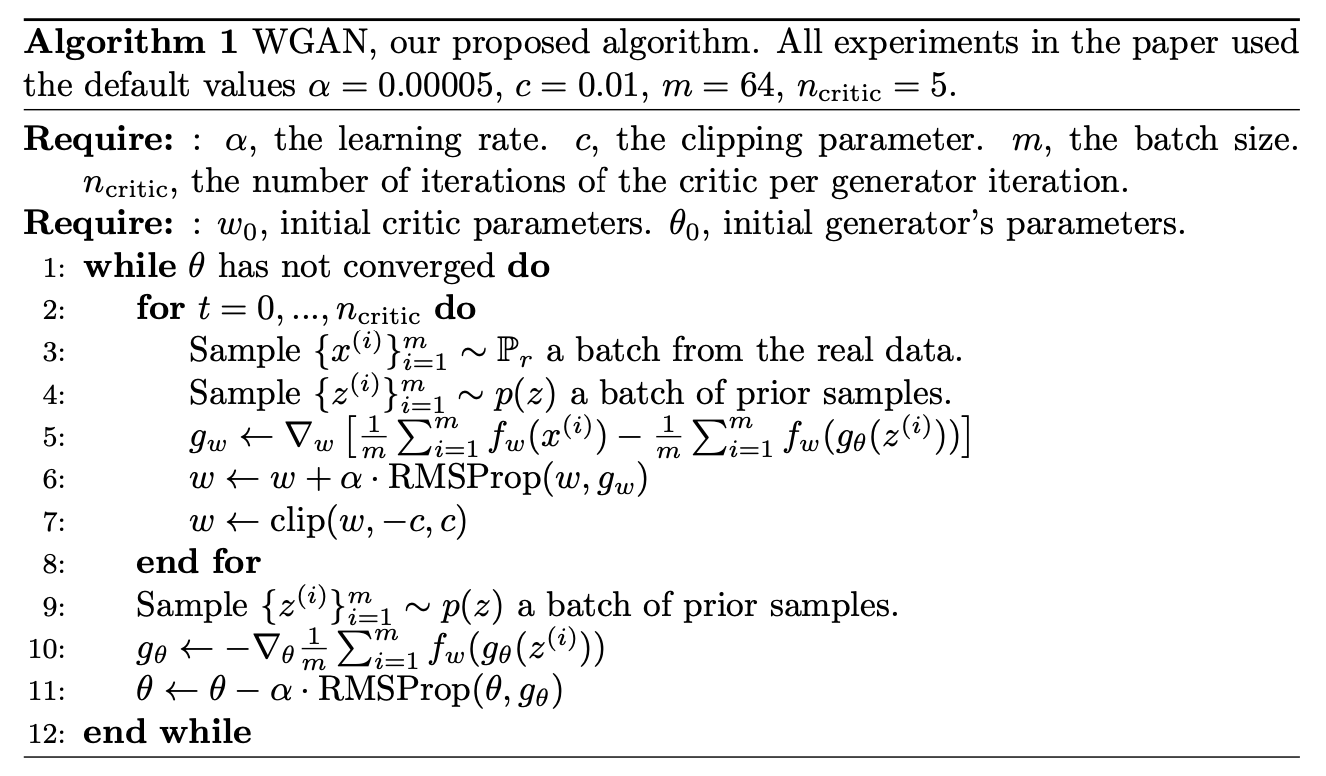

Note that
- we clip the domain of parameters to enforce Lipchitz continuity
- there's no $\log$ in loss functions
- we use **gradient ascent** to update $\theta^D$
- the output layer is is not `nn.Sigmoid` since the discriminator now is doing **regression** on two distances, not logistic regression.

# References
- I. Goodfellow et al. Generative Adversarial Nets, In *Neural Information Processing Systems*, 2014. 
- I. Goodfellow. NIPS 2016 Tutorial: Generative Adversarial Networks, In *Neural Information Processing Systems*, 2016.
- M. Arjovsky et al. Towards Principled Methods for Training Generative Adversarial Networks, 2017.
- M. Arjovsky et al. Wasserstein Generative Adversarial Networks, *Proceedings of the 34th International Conference on Machine Learning*, 2017.